<a href="https://colab.research.google.com/github/amara929/amara929/blob/main/Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Install Required Libraries**

In [ ]:
!pip install tensorflow matplotlib numpy

# **Step 2: Import Necessary Modules**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import time
import os

# **Step 3: Load and Prepare Dataset**

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


# **Step 4: Build the Generator Model**

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

generator = make_generator_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **Step 5: Build the Discriminator Model**

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **Step 6: Define Loss Functions and Optimizers**

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# **Step 7: Define Training Loop**

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        # Generate and save images every epoch
        generate_and_save_images(generator, epoch + 1, seed)

        print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}, Time: {time.time()-start}')

    # Generate after the final epoch
    generate_and_save_images(generator, epochs, seed)

# **Step 8: Create Image Generation Function**

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# **Step 9: Train the GAN**

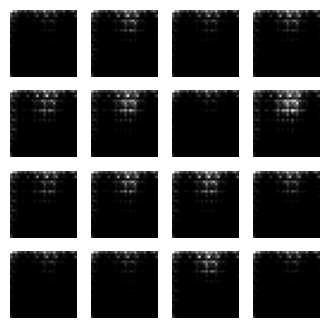

Epoch 1, Generator Loss: 0.6699407696723938, Discriminator Loss: 1.3597230911254883, Time: 24.185046195983887


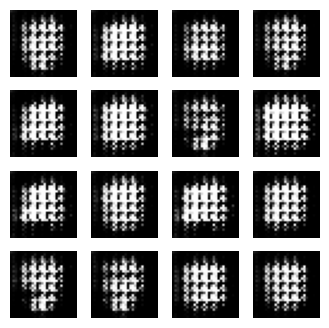

Epoch 2, Generator Loss: 0.8242055177688599, Discriminator Loss: 1.2019474506378174, Time: 13.131028890609741


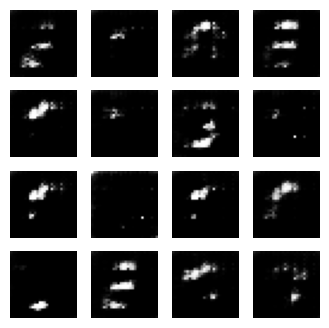

Epoch 3, Generator Loss: 1.0661712884902954, Discriminator Loss: 1.0187067985534668, Time: 13.53227424621582


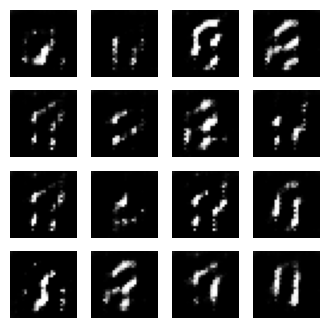

Epoch 4, Generator Loss: 1.0137951374053955, Discriminator Loss: 1.0205504894256592, Time: 13.1575927734375


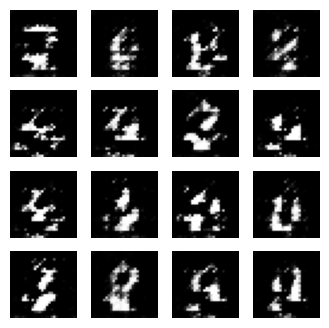

Epoch 5, Generator Loss: 1.014611840248108, Discriminator Loss: 1.2293128967285156, Time: 12.821418523788452


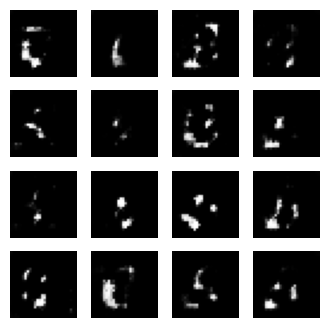

Epoch 6, Generator Loss: 0.6575524806976318, Discriminator Loss: 1.8441112041473389, Time: 12.741990327835083


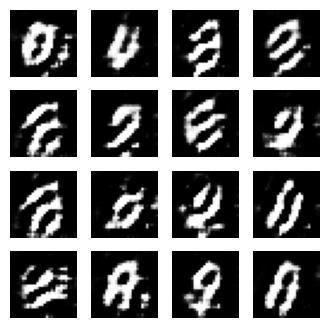

Epoch 7, Generator Loss: 0.7762900590896606, Discriminator Loss: 1.2624828815460205, Time: 13.0453040599823


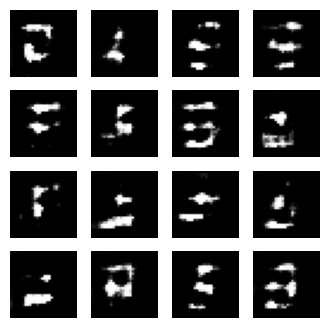

Epoch 8, Generator Loss: 0.9487183690071106, Discriminator Loss: 1.0998687744140625, Time: 12.897987604141235


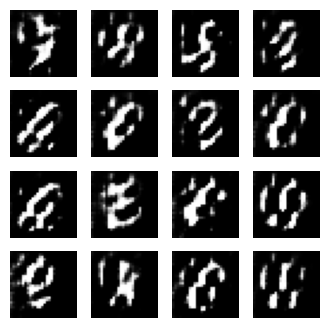

Epoch 9, Generator Loss: 0.8936091661453247, Discriminator Loss: 1.2844946384429932, Time: 13.118246078491211


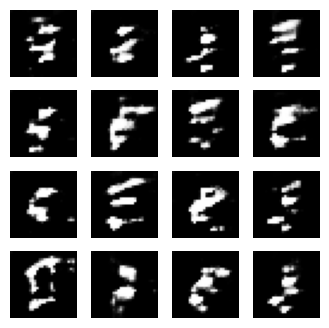

Epoch 10, Generator Loss: 0.8919712901115417, Discriminator Loss: 1.1601955890655518, Time: 13.185314178466797


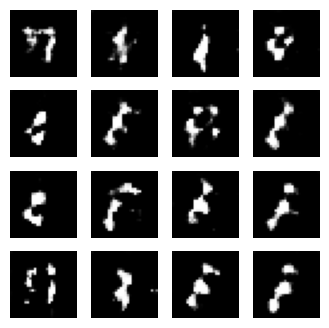

Epoch 11, Generator Loss: 0.8179963827133179, Discriminator Loss: 1.3684799671173096, Time: 12.977583885192871


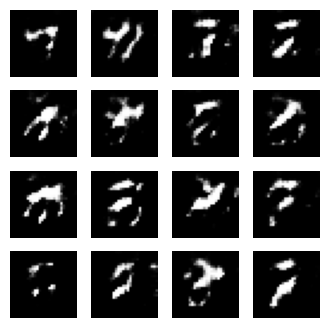

Epoch 12, Generator Loss: 0.7773097157478333, Discriminator Loss: 1.501009225845337, Time: 13.122216939926147


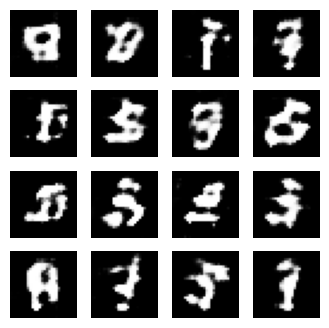

Epoch 13, Generator Loss: 0.8589869141578674, Discriminator Loss: 1.2188811302185059, Time: 12.830821990966797


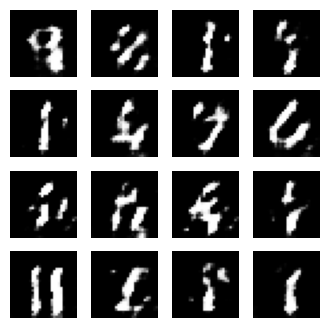

Epoch 14, Generator Loss: 1.0892622470855713, Discriminator Loss: 1.108324646949768, Time: 12.86658763885498


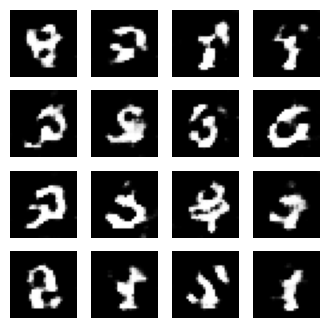

Epoch 15, Generator Loss: 1.024675965309143, Discriminator Loss: 1.363008975982666, Time: 12.88600492477417


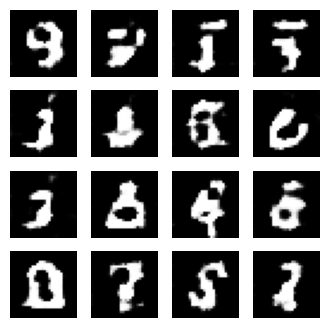

Epoch 16, Generator Loss: 1.027764081954956, Discriminator Loss: 1.3696539402008057, Time: 12.919027090072632


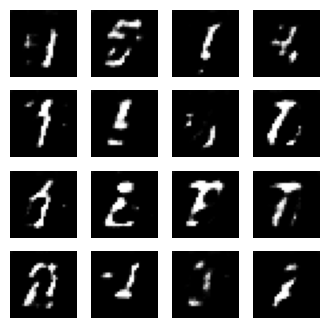

Epoch 17, Generator Loss: 1.1372500658035278, Discriminator Loss: 1.2050628662109375, Time: 12.945499658584595


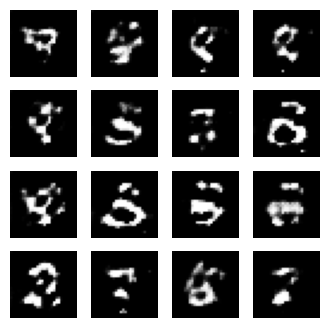

Epoch 18, Generator Loss: 1.052651047706604, Discriminator Loss: 1.0995347499847412, Time: 12.948132991790771


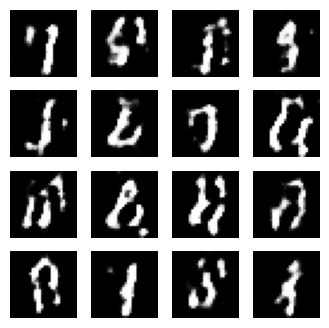

Epoch 19, Generator Loss: 1.123701810836792, Discriminator Loss: 0.987449049949646, Time: 13.235018491744995


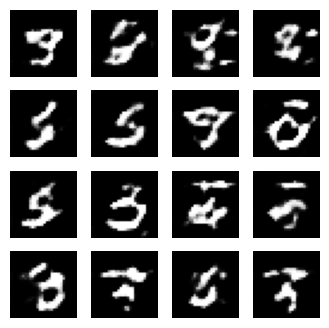

Epoch 20, Generator Loss: 1.119226098060608, Discriminator Loss: 1.0449483394622803, Time: 12.936059474945068


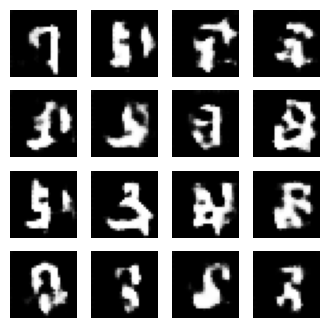

Epoch 21, Generator Loss: 1.0060521364212036, Discriminator Loss: 1.1283633708953857, Time: 13.08181381225586


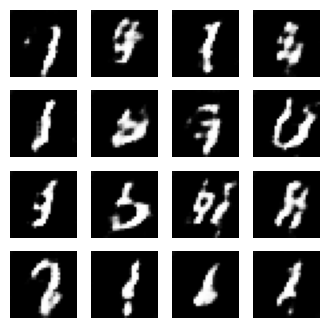

Epoch 22, Generator Loss: 1.0475091934204102, Discriminator Loss: 1.1558318138122559, Time: 13.098876953125


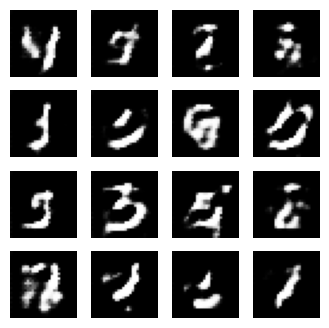

Epoch 23, Generator Loss: 1.1869194507598877, Discriminator Loss: 1.170037031173706, Time: 12.996760845184326


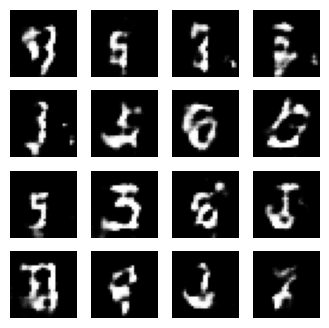

Epoch 24, Generator Loss: 1.203999638557434, Discriminator Loss: 1.1845498085021973, Time: 12.941312551498413


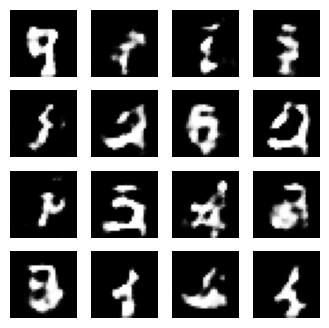

Epoch 25, Generator Loss: 1.2910099029541016, Discriminator Loss: 1.1228488683700562, Time: 13.216968059539795


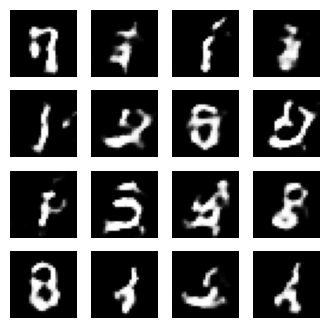

Epoch 26, Generator Loss: 1.2967774868011475, Discriminator Loss: 1.0836902856826782, Time: 12.932560443878174


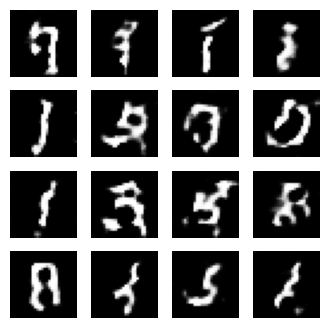

Epoch 27, Generator Loss: 1.3771607875823975, Discriminator Loss: 0.8874586820602417, Time: 12.914173126220703


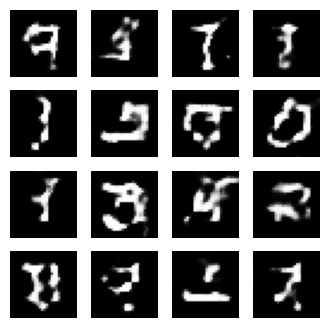

Epoch 28, Generator Loss: 1.6903868913650513, Discriminator Loss: 0.6711648106575012, Time: 12.91694974899292


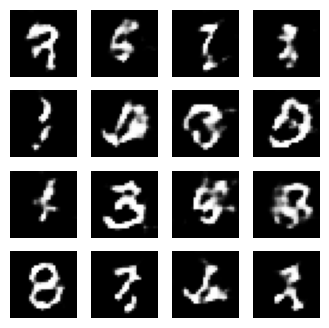

Epoch 29, Generator Loss: 1.0647945404052734, Discriminator Loss: 1.153210163116455, Time: 12.93834114074707


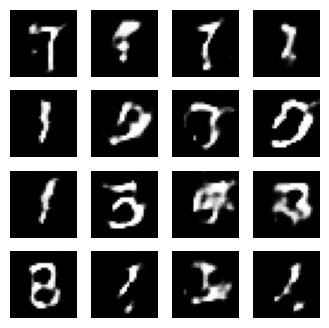

Epoch 30, Generator Loss: 1.5070165395736694, Discriminator Loss: 0.8304967284202576, Time: 13.241359233856201


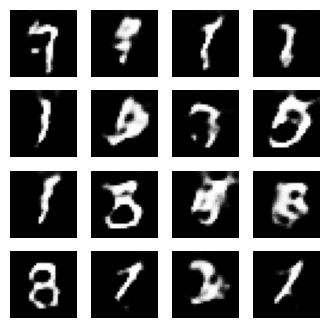

Epoch 31, Generator Loss: 1.162048578262329, Discriminator Loss: 1.056390643119812, Time: 12.953410148620605


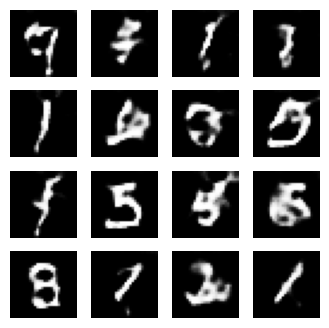

Epoch 32, Generator Loss: 0.9732943177223206, Discriminator Loss: 1.219394564628601, Time: 12.94856333732605


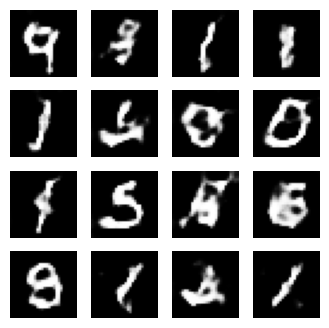

Epoch 33, Generator Loss: 1.1473109722137451, Discriminator Loss: 1.1566884517669678, Time: 13.074293851852417


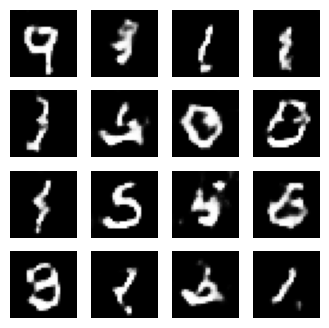

Epoch 34, Generator Loss: 1.1402009725570679, Discriminator Loss: 1.135939121246338, Time: 13.076288223266602


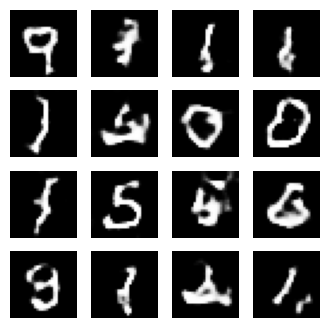

Epoch 35, Generator Loss: 1.1704480648040771, Discriminator Loss: 0.9587780237197876, Time: 12.943132400512695


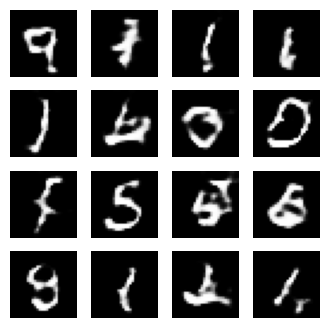

Epoch 36, Generator Loss: 1.1623567342758179, Discriminator Loss: 1.2545621395111084, Time: 12.936517715454102


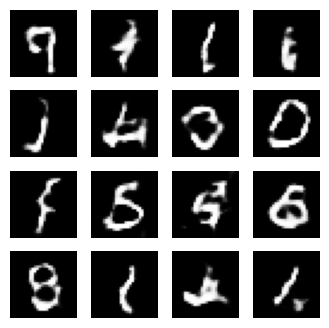

Epoch 37, Generator Loss: 1.088117003440857, Discriminator Loss: 1.0441347360610962, Time: 13.206063508987427


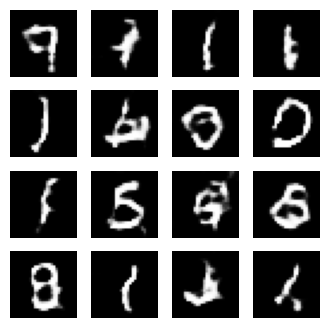

Epoch 38, Generator Loss: 1.004286766052246, Discriminator Loss: 1.2219173908233643, Time: 12.933717727661133


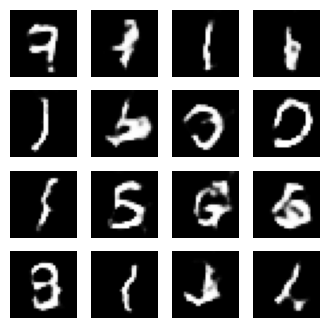

Epoch 39, Generator Loss: 1.1112980842590332, Discriminator Loss: 1.1174712181091309, Time: 12.990951538085938


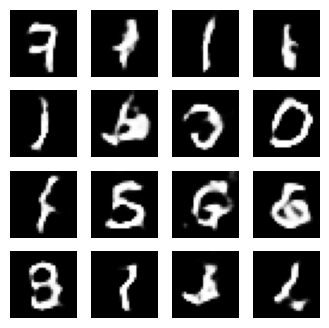

Epoch 40, Generator Loss: 0.8758899569511414, Discriminator Loss: 1.1267467737197876, Time: 12.943299770355225


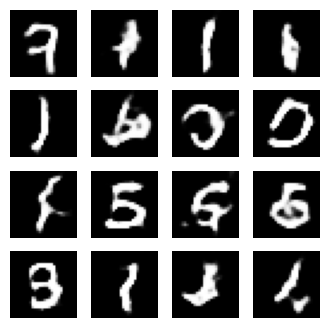

Epoch 41, Generator Loss: 0.8737855553627014, Discriminator Loss: 1.239011287689209, Time: 12.927268505096436


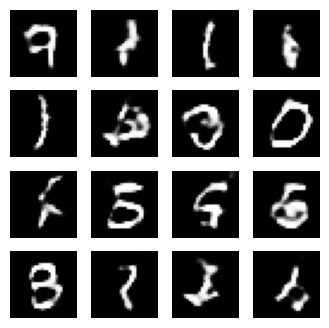

Epoch 42, Generator Loss: 0.9273784160614014, Discriminator Loss: 1.4753122329711914, Time: 12.949075698852539


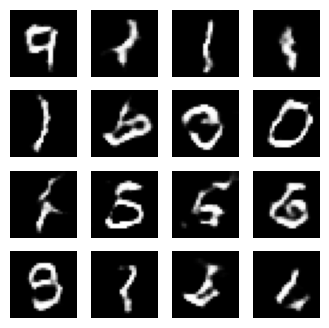

Epoch 43, Generator Loss: 0.909121572971344, Discriminator Loss: 1.322216510772705, Time: 13.209778308868408


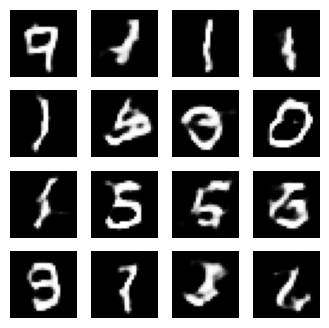

Epoch 44, Generator Loss: 0.9983011484146118, Discriminator Loss: 1.2583128213882446, Time: 12.910710573196411


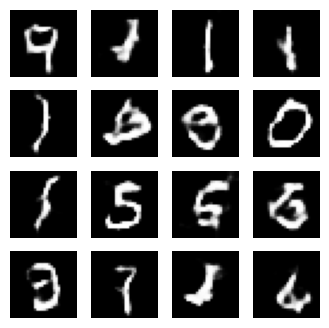

Epoch 45, Generator Loss: 1.0319887399673462, Discriminator Loss: 1.1418960094451904, Time: 13.0527822971344


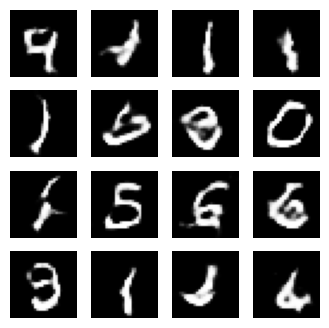

Epoch 46, Generator Loss: 1.1256824731826782, Discriminator Loss: 1.045042872428894, Time: 13.096760511398315


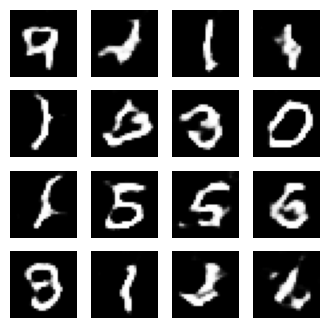

Epoch 47, Generator Loss: 0.8778324127197266, Discriminator Loss: 1.3820562362670898, Time: 12.962444305419922


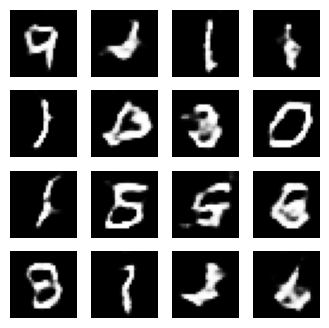

Epoch 48, Generator Loss: 1.0684796571731567, Discriminator Loss: 1.1735424995422363, Time: 12.941955327987671


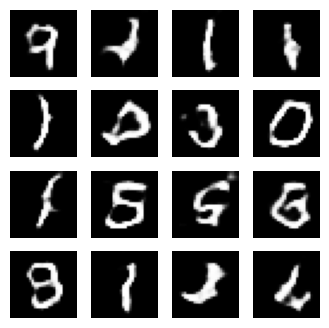

Epoch 49, Generator Loss: 0.9666644334793091, Discriminator Loss: 1.2739040851593018, Time: 13.209137201309204


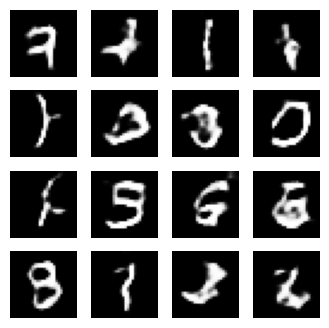

Epoch 50, Generator Loss: 1.0222461223602295, Discriminator Loss: 1.301630973815918, Time: 12.928277969360352


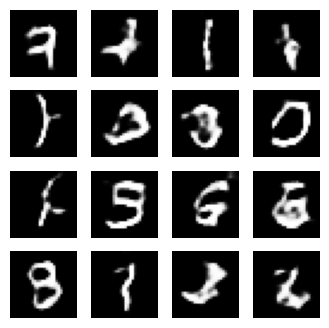

In [ ]:
train(train_dataset, EPOCHS)

# **Step 10:Save the Model**

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')